# Causal Machine Learning Tutorial

This is a tutorial in using two different causal machine learning approaches: targeted maximum likelihood estimation (TMLE) and double/debiased machine learning (DML). These methods are both going to be used to estimate the treatment effect for a binary treatment.  
  
This is strongly based on a tutorial given in: https://migariane.github.io/TMLE.nb.html, which implemented TMLE in `R` and https://github.com/matthewvowels1/TargetedLearningTutorial which implemented TMLE on the same problem in `Python`. Here, both are to be implemented in `Python` and we will compare the performance of TMLE and DML.  
  
See the paper here: *Luque-Fernandez MA, Schomaker M, Rachet B, Schnitzer ME. Targeted maximum likelihood estimation for a binary treatment: A tutorial. Statistics in Medicine. 2018; 37: 2530–2546. https://doi.org/10.1002/sim.7628*

In [4]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf # allows R-like syntax 

import matplotlib.pyplot as plt

from scipy.special import expit 

from tmle import targeting_step

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

from tutorial import generate_data, produce_dag


### Data Generating Function
  
Causal ML is about inferring parameters of some data generating function.
  
A key element is the DAG, we work off the following DAG (taken directly from the paper). This DAG is intended to simulate the causal pathway for mortality from cancer treatment 
  
We then generate date based on that DAG:
- `W1` ('sex') and `W2` ('age category') are generated as Bernoulli variables with probabibility 0.5 and 0.65 respectively 
- `W3` ('cancer stage') and `W4` ('comorbidities') are generated as ordinal variables with 4 and 5 levels respectively. The value for each is generated as a random uniform distribution and the values are rounded off to the closest integer
- `A` ('treatment variable') and `Y` ('outcome variable') are generated as binary indicators using a log-linear model. In the treatment and outcome models, there is an interaction term between `W2` and `W4` based on e.g. 'increased risk of comorbidities among older adults' 

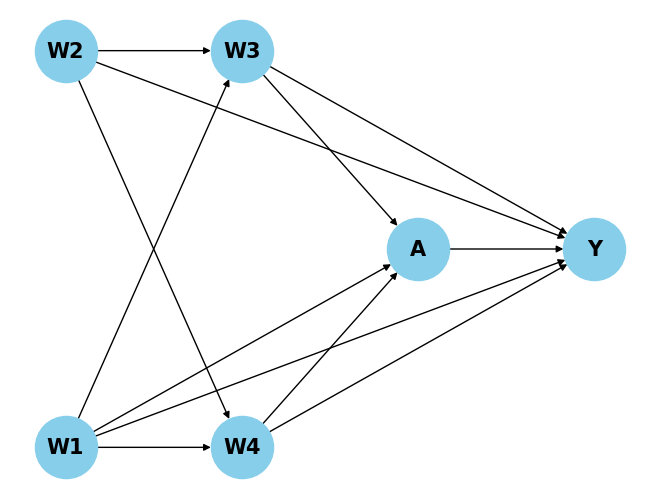

In [5]:
fig = produce_dag()
plt.show()

In [ ]:
df = generate_data(2000000, 555) # generate a huge dataset from which we can calculate the 'true' ATE

true_EY1 = df['Y1'].mean()
true_EY0 = df['Y0'].mean()
true_ATE = true_EY1-true_EY0
print(f'True ATE = {true_ATE}')

In [ ]:
# now generate a much smaller dataset that we will actually use for our methods
df = generate_data(10000, 556)
df

# TMLE  

### 1) Using a binary logistic regression model  
  
First, we deliberately misspecify the outcome and treatment models (ignoring the interaction term that we know exists)  
This is to show that TMLE can still work in this case and reduce bias

In [51]:
# first, we implement an intentionally wrong model (binary logistic regression, without the interaction terms)

# this is the outcome model, fit a binary logistic regression for it 
model = smf.logit("Y ~ A + w1 + w2 + w3 + w4", data=df)
model = model.fit()

print(model.summary())


# we create a new dataset where the treatment variables are set to 1 and 0 

newdata_A1 = df.copy()
newdata_A1['A'] = 1

newdata_A0 = df.copy()
newdata_A0['A'] = 0

# predict probabilities based on this data 
QAW = model.predict(df) # what does our model predict the outcome as (probability)
Q1W = model.predict(newdata_A1) # what if the patient had been treated
Q0W = model.predict(newdata_A0) # what if the patient had not been treated

# initial ATE estimate: 
init_ATE_est = Q1W.mean() - Q0W.mean() # difference in outcome if every patient treated vs every patient not treated
print(f'Initial (biased) ATE estimate = {init_ATE_est}')

Optimization terminated successfully.
         Current function value: 0.607563
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                 0.08721
Time:                        10:30:09   Log-Likelihood:                -6075.6
converged:                       True   LL-Null:                       -6656.1
Covariance Type:            nonrobust   LLR p-value:                8.525e-249
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1873      0.070    -16.972      0.000      -1.324      -1.050
A              0.8134      0.

In [52]:
# this is the treatment model (propensity score) 
ps_model = smf.logit("A ~ w1 + w2 + w3 + w4", data=df)
ps_model = ps_model.fit()
print(ps_model.summary())

# use this model to calculate propensity scores 
gW = ps_model.predict(df)

Optimization terminated successfully.
         Current function value: 0.335604
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      A   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.2144
Time:                        10:30:09   Log-Likelihood:                -3356.0
converged:                       True   LL-Null:                       -4271.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8512      0.143    -40.835      0.000      -6.132      -5.570
w1            -0.0393      0.

In [53]:
target_model = targeting_step(df, gW, QAW) # carries out the targeting step to optimise the b-v tradeoff for the ATE
epsilon = target_model.params # coefficients in this targeting step

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6074.6
Date:                Thu, 21 Nov 2024   Deviance:                       12149.
Time:                        10:30:09   Pearson chi2:                 1.00e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0001960
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H0W            0.0031      0.019      0.161      0.8

In [54]:
# use the epsilon values to improve the treatment model

# Convert Q0W and Q1W to logit scale and update them
logit_Q0W = np.log(Q0W / (1 - Q0W))
logit_Q1W = np.log(Q1W / (1 - Q1W))

# Update logit values with epsilon adjustments
logit_Q0W_1 = logit_Q0W + epsilon['H0W'] / (1 - gW)
logit_Q1W_1 = logit_Q1W + epsilon['H1W'] / gW

# Convert back to probabilities using inverse-logit
Q0W_1 = expit(logit_Q0W_1)
Q1W_1 = expit(logit_Q1W_1)

# Now we can calculate an improved ATE
EY1_tmle_1 = Q1W_1.mean()
EY0_tmle_1 = Q0W_1.mean()
ATE_tmle_1 = EY1_tmle_1 - EY0_tmle_1

In [55]:
# combine all of this info into a new table 
new_df = pd.DataFrame({
    'Q0W': Q0W,
    'Q1W': Q1W,
    'gW': gW,
    'Q0W_1': Q0W_1,
    'Q1W_1': Q1W_1,
    'Treatment_Effect': Q1W_1 - Q0W_1
})

# Set the index of the new DataFrame to match the index of the original df (patient id)
new_df.index = df.index

final_df = df.join(new_df, how='inner') # dataframes are joined on index

final_df

,w1,w2,w3,w4,A,Y,Y1,Y0,Q0W,Q1W,gW,Q0W_1,Q1W_1,Treatment_Effect
0,1.0,1.0,3.380,2.750,0.0,1.0,0.0,1.0,0.734167,0.861670,0.202767,0.734931,0.864205,0.129274
1,0.0,0.0,3.994,3.031,0.0,1.0,1.0,1.0,0.666183,0.818220,0.091842,0.666947,0.825151,0.158204
2,1.0,1.0,0.040,4.536,1.0,1.0,1.0,1.0,0.656060,0.811403,0.377572,0.657192,0.813158,0.155966
3,1.0,0.0,2.001,3.052,0.0,1.0,1.0,1.0,0.490919,0.685041,0.060540,0.491750,0.700317,0.208567
4,0.0,0.0,0.007,4.160,0.0,1.0,0.0,1.0,0.492625,0.686512,0.104653,0.493498,0.695378,0.201881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,1.777,2.746,0.0,1.0,1.0,1.0,0.693199,0.835962,0.157206,0.693987,0.839717,0.145730
9996,1.0,1.0,0.777,4.488,1.0,1.0,1.0,1.0,0.695004,0.837124,0.405263,0.696116,0.838581,0.142464
9997,1.0,1.0,1.428,2.478,0.0,0.0,1.0,0.0,0.606817,0.776835,0.115846,0.607660,0.783270,0.175610
9998,0.0,1.0,1.843,1.945,0.0,1.0,0.0,1.0,0.647863,0.805812,0.084869,0.648642,0.813699,0.165057


In [56]:
# compare ATE estimate (corrected) to naive ATE and true estimate
print("="*50)
print(f'Initial (uncorrected) ATE estimate = {init_ATE_est}')
print(f'Absolute bias (from true value) = {abs(init_ATE_est-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(init_ATE_est-true_ATE)*100/true_ATE}%')
print("="*50)
print(f'Corrected (by TMLE) ATE estimate = {ATE_tmle_1}')
print(f'Absolute bias (from true value) = {abs(ATE_tmle_1-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(ATE_tmle_1-true_ATE)*100/true_ATE}%')
print("="*50)

Initial (uncorrected) ATE estimate = 0.16147770596532363
Absolute bias (from true value) = 0.0317627940346763
Percentage bias (from true value) = 16.43692395469703%
Corrected (by TMLE) ATE estimate = 0.18631804269111385
Absolute bias (from true value) = 0.006922457308886076
Percentage bias (from true value) = 3.5823014890181297%


### 2) Using a ML model  
  
Now we use ML models for the treatment and outcome models, which should be more robust to bias and model misspecification

In [ ]:

# Define predictors and outcome
X = df[['A', 'w1', 'w2', 'w3', 'w4']]  # Covariates and treatment
y = df['Y']  # Outcome

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
gb_model.fit(X, y)

QA = gb_model.predict_proba(X)[:,1]
Q1 = gb_model.predict_proba(newdata_A1[['A', 'w1', 'w2', 'w3', 'w4']])[:,1]
Q0 = gb_model.predict_proba(newdata_A0[['A', 'w1', 'w2', 'w3', 'w4']])[:,1]

In [58]:
ml_ATE_est_no_target = Q1.mean() - Q0.mean() # initial estimate of ATE using superlearner, but no targeting
print(ml_ATE_est_no_target)

0.16403551801820782


In [59]:
# Define predictors and outcome
X = df[['w1', 'w2', 'w3', 'w4']]  # Covariates and treatment
y = df['A']  # Outcome

# Initialize the Gradient Boosting model
ps_model_ml = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model
ps_model_ml.fit(X, y)

propensity_estimates_ml = ps_model_ml.predict_proba(X)[:,1]

In [68]:
target_model = targeting_step(df, propensity_estimates_ml, QA) # carries out the targeting step to optimise the b-v tradeoff for the ATE
epsilon = target_model.params # coefficients in this targeting step

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5988.7
Date:                Thu, 21 Nov 2024   Deviance:                       11977.
Time:                        10:53:21   Pearson chi2:                 9.63e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001246
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H0W           -0.0316      0.020     -1.608      0.1

In [ ]:
# use the epsilon values to improve the treatment model

# Convert Q0W and Q1W to logit scale and update them
logit_Q0 = np.log(Q0 / (1 - Q0))
logit_Q1 = np.log(Q1 / (1 - Q1))

# Update logit values with epsilon adjustments
logit_Q0_1 = logit_Q0 + epsilon['H0W'] / (1 - propensity_estimates_ml)
logit_Q1_1 = logit_Q1 + epsilon['H1W'] / propensity_estimates_ml

# Convert back to probabilities using inverse-logit
Q0_1 = expit(logit_Q0_1)
Q1_1 = expit(logit_Q1_1)

# Now we can calculate an improved ATE
EY1_tmle_2 = Q1_1.mean()
EY0_tmle_2 = Q0_1.mean()
ATE_tmle_2 = EY1_tmle_2 - EY0_tmle_2


In [71]:
# compare ATE estimate (corrected) to naive ATE and true estimate
print("="*50)
print(f'Initial (uncorrected) ATE estimate using ML = {ml_ATE_est_no_target}')
print(f'Absolute bias (from true value) = {abs(ml_ATE_est_no_target-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(ml_ATE_est_no_target-true_ATE)*100/true_ATE}%')
print("="*50)
print(f'Corrected (by TMLE) ATE estimate using ML = {ATE_tmle_2}')
print(f'Absolute bias (from true value) = {abs(ATE_tmle_2-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(ATE_tmle_2-true_ATE)*100/true_ATE}%')

Initial (uncorrected) ATE estimate using ML = 0.16403551801820782
Absolute bias (from true value) = 0.02920498198179211
Percentage bias (from true value) = 15.113282144163424%
Corrected (by TMLE) ATE estimate using ML = 0.20117783691003777
Absolute bias (from true value) = 0.00793733691003784
Percentage bias (from true value) = 4.107491395456875%


### 3) Using stacked classifiers (superlearner)  
  
This approach uses an ensemble of ML methods, as recommended by the developers of the TMLE `R` package

In [ ]:
# Define predictors and outcome
X = df[['A', 'w1', 'w2', 'w3', 'w4']]  # Covariates and treatment
y = df['Y']  # Outcome

# Define base models
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X, y)

# Predict probabilities
QA = stacking_model.predict_proba(X)[:,1]
Q1 = stacking_model.predict_proba(newdata_A1[['A', 'w1', 'w2', 'w3', 'w4']])[:,1]
Q0 = stacking_model.predict_proba(newdata_A0[['A', 'w1', 'w2', 'w3', 'w4']])[:,1]

In [65]:
sl_ATE_est_no_target = Q1.mean() - Q0.mean() # initial estimate of ATE using superlearner, but no targeting
print(sl_ATE_est_no_target)

0.10928529809729359


In [66]:
# Define predictors and outcome
X = df[['w1', 'w2', 'w3', 'w4']]  # Covariates and treatment
y = df['A']  # Outcome

# Define base models
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, kernel='linear', random_state=42))
]

# Define meta-model
meta_model = LogisticRegression()

# Create the stacking classifier
stacking_model_ps = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model_ps.fit(X, y)

StackingClassifier(cv=5,
                   estimators=[('gradient_boosting',
                                GradientBoostingClassifier(random_state=42)),
                               ('random_forest',
                                RandomForestClassifier(random_state=42)),
                               ('svm',
                                SVC(kernel='linear', probability=True,
                                    random_state=42))],
                   final_estimator=LogisticRegression())

In [72]:
propensity_estimates_sl = stacking_model_ps.predict_proba(X)[:,1]

In [73]:
target_model = targeting_step(df, propensity_estimates_sl, QA) # carries out the targeting step to optimise the b-v tradeoff for the ATE
epsilon = target_model.params # coefficients in this targeting step

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5987.9
Date:                Thu, 21 Nov 2024   Deviance:                       11976.
Time:                        10:54:12   Pearson chi2:                 9.67e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001417
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H0W           -0.0315      0.020     -1.590      0.1

In [74]:
# use the epsilon values to improve the treatment model

# Convert Q0W and Q1W to logit scale and update them
logit_Q0 = np.log(Q0 / (1 - Q0))
logit_Q1 = np.log(Q1 / (1 - Q1))

# Update logit values with epsilon adjustments
logit_Q0_1 = logit_Q0 + epsilon['H0W'] / (1 - propensity_estimates_sl)
logit_Q1_1 = logit_Q1 + epsilon['H1W'] / propensity_estimates_sl

# Convert back to probabilities using inverse-logit
Q0_1 = expit(logit_Q0_1)
Q1_1 = expit(logit_Q1_1)

# Now we can calculate an improved ATE
EY1_tmle_3 = Q1_1.mean()
EY0_tmle_3 = Q0_1.mean()
ATE_tmle_3 = EY1_tmle_3 - EY0_tmle_3


In [75]:
# compare ATE estimate (corrected) to naive ATE and true estimate
print("="*50)
print(f'Initial (uncorrected) ATE estimate using ML = {sl_ATE_est_no_target}')
print(f'Absolute bias (from true value) = {abs(sl_ATE_est_no_target-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(sl_ATE_est_no_target-true_ATE)*100/true_ATE}%')
print("="*50)
print(f'Corrected (by TMLE) ATE estimate using ML = {ATE_tmle_3}')
print(f'Absolute bias (from true value) = {abs(ATE_tmle_3-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(ATE_tmle_3-true_ATE)*100/true_ATE}%')

Initial (uncorrected) ATE estimate using ML = 0.10928529809729359
Absolute bias (from true value) = 0.08395520190270633
Percentage bias (from true value) = 43.445965986791784%
Corrected (by TMLE) ATE estimate using ML = 0.19121143105535898
Absolute bias (from true value) = 0.002029068944640944
Percentage bias (from true value) = 1.0500226115337854%


### TMLE Summary 
- Superlearner outperforms the misspecified model or the individual ML model in terms of getting closest to the true ATE value

# Double ML